# Wells Fargo Case Study 

### displaying software versions and importing our training and test datasets for EDA

In [1]:
from platform import python_version
print("Python version in use:",python_version())
import pandas as pd
print("Pandas version in use:",pd.__version__)
import numpy as np
from numpy import mean
from numpy import std
print("Numpy version in use:",np.__version__)
# I don't want to import the entire sklearn package, so I will hand select what I need 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, accuracy_score, recall_score, precision_recall_curve, precision_score 
from sklearn.ensemble import AdaBoostClassifier
print("Sklearn version in use: 0.19.1")
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
print("mlxtend version in use: 0.18.0")
import statsmodels
print("Statsmodels version in use:", statsmodels.__version__)
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor 


#importing the training and test datasets that were provided
train_data = pd.read_csv('../Case-study-training-data-1-11-2021.csv')
test_data = pd.read_csv('../Case-study-test-data-1-11-2021.csv')

print(train_data.shape) 
print(test_data.shape) 

Python version in use: 3.6.8
Pandas version in use: 1.1.5
Numpy version in use: 1.15.4
Sklearn version in use: 0.19.1
mlxtend version in use: 0.18.0
Statsmodels version in use: 0.9.0
(20000, 21)
(5000, 21)


# 1) Exploratory Data Analysis

In [41]:
# printing out the columns of the dataset and viewing the first few rows of the 

print(train_data.columns) 
train_data.head()
len(train_data[train_data['Def_ind'] == 1]) / (len(train_data['Def_ind'])) 

Index(['tot_balance', 'avg_bal_cards', 'credit_age', 'credit_age_good_account',
       'credit_card_age', 'num_acc_30d_past_due_12_months',
       'num_acc_30d_past_due_6_months', 'num_mortgage_currently_past_due',
       'tot_amount_currently_past_due', 'num_inq_12_month',
       'num_card_inq_24_month', 'num_card_12_month', 'num_auto_ 36_month',
       'uti_open_card', 'pct_over_50_uti', 'uti_max_credit_line',
       'pct_card_over_50_uti', 'ind_XYZ', 'rep_income', 'rep_education',
       'Def_ind', 'NaN_Flag'],
      dtype='object')


0.10190356091995437

In [3]:
print("Training data # of rows:",len(train_data))
print("Testing data # of rows:",len(test_data))

Training data # of rows: 20000
Testing data # of rows: 5000


In [4]:
train_data.mean()

tot_balance                        107439.032714
avg_bal_cards                       12230.735330
credit_age                            280.710050
credit_age_good_account               146.100300
credit_card_age                       285.120850
num_acc_30d_past_due_12_months          0.156550
num_acc_30d_past_due_6_months           0.029700
num_mortgage_currently_past_due         0.030000
tot_amount_currently_past_due         352.496791
num_inq_12_month                        0.616050
num_card_inq_24_month                   1.053050
num_card_12_month                       0.272950
num_auto_ 36_month                      0.164150
uti_open_card                           0.490867
pct_over_50_uti                         0.484157
uti_max_credit_line                     0.465007
pct_card_over_50_uti                    0.550964
ind_XYZ                                 0.250000
rep_income                         166373.900129
Def_ind                                 0.100000
dtype: float64

In [5]:
# checking for NA or unusual values: 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

tot_balance                           0
avg_bal_cards                         0
credit_age                            0
credit_age_good_account               0
credit_card_age                       0
num_acc_30d_past_due_12_months        0
num_acc_30d_past_due_6_months         0
num_mortgage_currently_past_due       0
tot_amount_currently_past_due         0
num_inq_12_month                      0
num_card_inq_24_month                 0
num_card_12_month                     0
num_auto_ 36_month                    0
uti_open_card                         0
pct_over_50_uti                       0
uti_max_credit_line                   0
pct_card_over_50_uti               1958
ind_XYZ                               0
rep_income                         1559
rep_education                         1
Def_ind                               0
dtype: int64
tot_balance                          0
avg_bal_cards                        0
credit_age                           0
credit_age_good_account       

### It looks like there are a significant number of null values in the PCT_card_over_50_uti variable, rep_income, and maybe a few in rep_education in both the training and test sets. This is worth further exploration....

In [6]:
explore1 = train_data[train_data['pct_card_over_50_uti'].isna()]
# we have limited the dataframe to only the rows where percent card utilization over 50% is NAN, so we explore 
# reasons why this might be the case and if we need to remove these rows or replace the NAN value with something 
# useful for modeling 

# the number of card inquiries in the last two years and their value counts 
explore1['num_card_inq_24_month'].value_counts()

0     1272
1      230
2      137
3       75
4       73
5       59
6       39
7       30
9       14
10      13
8        9
11       3
12       2
15       1
14       1
Name: num_card_inq_24_month, dtype: int64

### Most of these accounts have very few credit inquiries in the last two years, but there are a handful that have 10 or more

In [7]:
# looking at the minumum credit card age in this group 
explore1['credit_card_age'].min()

54

### My second hypothesis was that there were null values because they didn't have a long enough history of credit. That doesn't seem to be the case since each account has a history of at least 4 years (54 months min )

In [8]:
## trying to see if many of these accounts have delinquent payments 
explore1['num_acc_30d_past_due_12_months'].value_counts()

## it looks like many of them have zero accounts with delinquent payments so this cant explain it either. 

0    1742
1     168
2      40
3       7
4       1
Name: num_acc_30d_past_due_12_months, dtype: int64

In [9]:
# presenting the mean values in each column for the records where pct_card_over_50_uti is NAN
explore1.mean()

tot_balance                        107280.222992
avg_bal_cards                       12244.222249
credit_age                            280.770174
credit_age_good_account               145.664964
credit_card_age                       284.594995
num_acc_30d_past_due_12_months          0.139428
num_acc_30d_past_due_6_months           0.027579
num_mortgage_currently_past_due         0.027579
tot_amount_currently_past_due         289.846154
num_inq_12_month                        0.633299
num_card_inq_24_month                   1.110317
num_card_12_month                       0.270174
num_auto_ 36_month                      0.161389
uti_open_card                           0.490473
pct_over_50_uti                         0.485442
uti_max_credit_line                     0.465901
pct_card_over_50_uti                         NaN
ind_XYZ                                 0.260981
rep_income                         165160.300224
Def_ind                                 0.084780
dtype: float64

### Nothing in particular is jumping out at me within these accounts that would lead me to believe there is something that can explain the NaN values. Since they make up a small chunk of the overall dataset, it may be useful to remove these columns where the values of pct_card_over_50_uti are NaN. 

### Other alternatives that could be explored would be to replace the NaN values with the average value of the other columns, or a step further would be to use another machine learning algorithm like K nearest neighbors to find accounts which are the most similar and assign their values for the column to the NaN accounts. 

In [10]:
## limiting dataset to where pct card over 50 utilization is not NaN. 
explore2 = train_data[train_data['pct_card_over_50_uti'].notna()]

In [11]:
# checking the number of null values after eliminating all of the pct_over_50_uti nulls. 
print(explore2.isnull().sum())

tot_balance                           0
avg_bal_cards                         0
credit_age                            0
credit_age_good_account               0
credit_card_age                       0
num_acc_30d_past_due_12_months        0
num_acc_30d_past_due_6_months         0
num_mortgage_currently_past_due       0
tot_amount_currently_past_due         0
num_inq_12_month                      0
num_card_inq_24_month                 0
num_card_12_month                     0
num_auto_ 36_month                    0
uti_open_card                         0
pct_over_50_uti                       0
uti_max_credit_line                   0
pct_card_over_50_uti                  0
ind_XYZ                               0
rep_income                         1389
rep_education                         0
Def_ind                               0
dtype: int64


In [12]:
# all rows where rep_income is NaN 
rep_income_na = explore2[explore2['rep_income'].isna()]
rep_income_na

,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,...,num_card_12_month,num_auto_ 36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,ind_XYZ,rep_income,rep_education,Def_ind
17,131165.35970,17224.62489,377,216,300,0,0,0,0.0,0,...,0,0,0.377815,0.447937,0.453836,0.594471,0,NaN,college,0
30,103304.86390,12456.41097,256,143,251,0,0,0,0.0,2,...,0,0,0.531698,0.482610,0.568419,0.469347,0,NaN,college,0
36,123010.53280,13723.87578,210,99,229,0,0,0,0.0,3,...,1,0,0.480494,0.357043,0.564049,0.579673,0,NaN,college,0
56,83295.10935,10816.61260,206,151,269,0,0,0,0.0,0,...,0,1,0.414403,0.317539,0.373204,0.497382,0,NaN,college,0
62,111457.62650,10876.99020,347,135,356,0,0,0,0.0,0,...,0,1,0.547103,0.345732,0.584647,0.576775,0,NaN,high_school,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,105055.06500,12779.36294,279,142,317,0,0,0,0.0,0,...,0,0,0.615384,0.584990,0.477244,0.765710,1,NaN,high_school,0
19975,102282.23070,16538.18384,230,97,231,0,0,0,0.0,0,...,1,0,0.545748,0.427411,0.378517,0.530880,0,NaN,high_school,0
19990,109331.52110,14733.48849,279,147,278,0,0,0,0.0,1,...,0,2,0.536290,0.450051,0.646805,0.547561,0,NaN,college,0
19992,118021.00220,17165.15858,330,172,328,0,0,0,0.0,0,...,0,0,0.424491,0.499234,0.436534,0.483930,1,NaN,college,0


In [13]:
# average of overall training dataset minus averages of data where rep income in NA
train_data.mean() - rep_income_na.mean()

tot_balance                        547.473176
avg_bal_cards                      -38.807678
credit_age                           1.983628
credit_age_good_account             -0.013451
credit_card_age                      2.245400
num_acc_30d_past_due_12_months      -0.008317
num_acc_30d_past_due_6_months       -0.007017
num_mortgage_currently_past_due     -0.004557
tot_amount_currently_past_due      -68.066562
num_inq_12_month                    -0.008860
num_card_inq_24_month               -0.029023
num_card_12_month                   -0.012147
num_auto_ 36_month                   0.005763
uti_open_card                        0.005414
pct_over_50_uti                      0.002651
uti_max_credit_line                  0.004320
pct_card_over_50_uti                 0.001943
ind_XYZ                             -0.000540
rep_income                                NaN
Def_ind                              0.001368
dtype: float64

### Other than a slightly higher total amount currently past due, I don't see a discernable difference between these at first glance. I'm currently unable to identify if the data is missing at random, missing completely at random, or missing not at random. I don't have any issue with completely dropping all rows with an NA value from both the training and test set for my first attempt at modeling. 

### If neccessary I will come back and perform the knn solution stated earlier to assign those columns the values of the most similar records. 

In [14]:
# knn_impute(target=train_data['pct_card_over_50_uti'], 
#            attributes=train_data[['avg_bal_cards', 'uti_open_card', 'uti_max_credit_line']], 1), 
#         aggregation_method="median", k_neighbors=10, numeric_distance='euclidean', 
#             categorical_distance ='hamming', missing_neighbors_threshold=0.8)

## In preparation for visualizing some of this data I'm going to flag our NaN values so that we can highlight where they are in comparison to the other data. 

In [15]:
# creating a new column based on 2 conditions that will have a 1 if there are na values and a 0 if not
train_data['NaN_Flag'] = np.where(train_data['pct_card_over_50_uti'].isna() | train_data['rep_income'].isna() , 1, 0)

In [16]:
len(train_data[train_data['NaN_Flag'] == 1]) 
# this value should be roughly 3k based on the values we saw earlier in our training set summary. 

3347

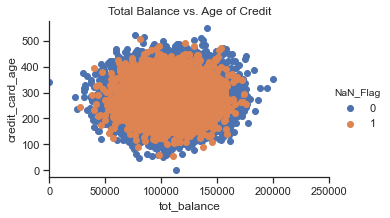

In [17]:
from  matplotlib import pyplot
import seaborn
seaborn.set(style='ticks')

# plotting the total balance vs. the age of credit 
fg = seaborn.FacetGrid(data=train_data, hue='NaN_Flag', aspect=1.61)
fg.map(pyplot.scatter, 'tot_balance', 'credit_card_age').add_legend()
fg.set(xlim=(0, 250000))
fg.set(title=("Total Balance vs. Age of Credit"))
fg

In [18]:
train_data['uti_max_credit_line']

0        0.513934
1        0.418016
2        0.341627
3        0.542940
4        0.632934
           ...   
19995    0.527230
19996    0.545108
19997    0.412155
19998    0.301612
19999    0.349246
Name: uti_max_credit_line, Length: 20000, dtype: float64

In [19]:
bins = pd.cut(train_data['uti_max_credit_line'], [0, .2, .4, .6, .8, 1])
df = train_data.groupby(bins)[['uti_max_credit_line', 'NaN_Flag']].agg(['count', 'sum'])
df

uti_max_credit_line              NaN_Flag      
                                  count          sum    count   sum
uti_max_credit_line                                                
(0.0, 0.2]                          454    68.434667      454    86
(0.2, 0.4]                         5687  1870.431006     5687   939
(0.4, 0.6]                        10865  5360.045342    10865  1820
(0.6, 0.8]                         2877  1903.279298     2877   487
(0.8, 1.0]                          116    97.942343      116    15

<AxesSubplot:>

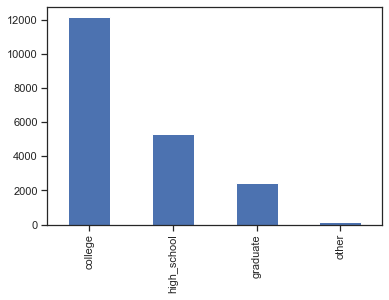

In [20]:
train_data['rep_education'].value_counts().plot(kind='bar')

# 2) Scaling Datasets and Cleaning for Modeling

In [21]:
# dropping NA values from the training and testing sets 
train_data = train_data.dropna()
test_data = test_data.dropna()

dummies_train = pd.get_dummies(train_data) 
dummies_test = pd.get_dummies(test_data)
# Getting dummies, and it actually just split out our rep_education into 4 separate binary columns

## Checking for Multicollinearity


In [22]:
### multicollinearity check 
feature_names = dummies_train.loc[:, ~dummies_train.columns.isin(['Def_ind', 'NaN_Flag'])].columns
vif_data = pd.DataFrame() 
vif_data["feature"] = feature_names 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(dummies_train.loc[:, ~dummies_train.columns.isin(['Def_ind', 'NaN_Flag'])].values, i) 
                          for i in range(len(feature_names))] 
  
print(vif_data)

                            feature        VIF
0                       tot_balance   1.997569
1                     avg_bal_cards   1.995462
2                        credit_age   5.485277
3           credit_age_good_account   2.775625
4                   credit_card_age   3.650556
5    num_acc_30d_past_due_12_months   3.205970
6     num_acc_30d_past_due_6_months   2.961915
7   num_mortgage_currently_past_due   2.954286
8     tot_amount_currently_past_due   4.112177
9                  num_inq_12_month   5.376700
10            num_card_inq_24_month   5.372542
11                num_card_12_month   1.015503
12               num_auto_ 36_month   1.013328
13                    uti_open_card   6.108150
14                  pct_over_50_uti   2.282061
15              uti_max_credit_line   2.282563
16             pct_card_over_50_uti   3.539874
17                          ind_XYZ   1.003294
18                       rep_income   1.001854
19            rep_education_college  58.899221
20           

### Anything exceeding 5-10 means there is very strong multicollinearity so something needs to be done with our rep_education variables. 

In [23]:
train_data['rep_education'].unique()

array(['college', 'graduate', 'high_school', 'other'], dtype=object)

In [24]:
## making the education related features into a single category based on our previous charts and the multicollinearity check

dummies_train['higher_ed'] = np.where((train_data['rep_education'] == 'graduate') | (train_data['rep_education'] == 'college') , 1, 0)
dummies_test['higher_ed'] = np.where((test_data['rep_education'] == 'graduate') | (test_data['rep_education'] == 'college') , 1, 0)

In [25]:
## additional multicollinearity checks can be done here 

# x = dummies_train.loc[:, ~dummies_train.columns.isin(['Def_ind', 'NaN_Flag', 'rep_education_college', 'rep_education_other', 'rep_education_high_school', 'rep_education_graduate'])].values


# ### multicollinearity check 
# vif_data = pd.DataFrame() 
# vif_data["feature"] = feature_names 
  
# # calculating VIF for each feature 
# vif_data["VIF"] = [variance_inflation_factor(x, i) 
#                           for i in range(len(feature_names))] 
  
# print(vif_data)



## There are a few methods here that I've thought about using to prepare the data 

### 1) I have seen some pretty interesting binning strategies where you create bins and expand the number of variable inputs into your model using weights of evidence to determine the bins. Then every predictor becomes a binary input. I like this strategy, but I dont like the complexity it adds in terms of the number of predictors with this small of a dataset. 

### 2) I have seen strategies where categorical variables are turned into binary 1's and 0's and the numerical data is scaled. I'm going to try this at first and see what kind of predictive power we have with that. 

In [26]:
# creating our response matrixes and features 
y_train = train_data['Def_ind'].values
y_test = test_data['Def_ind'].values
# gonna remove a few unwanted columns here while creating sets 
x_train = dummies_train.loc[:, ~dummies_train.columns.isin(['Def_ind', 'NaN_Flag', 'rep_education_college', 'rep_education_other', 'rep_education_high_school', 'rep_education_graduate'])].values
x_test = dummies_test.loc[:, ~dummies_test.columns.isin(['Def_ind', 'rep_education_college', 'rep_education_other', 'rep_education_high_school', 'rep_education_graduate'])].values

# using the minmax scaler so that all of our data will be on a 0-1 scale 
## train data 

scale = MinMaxScaler()
data_scaled_train = scale.fit_transform(x_train)
# to add back the column names I'll perform the code below
#data_scaled_train = pd.DataFrame(data_scaled_train, columns = x_train.columns)

#Test data scaled and column names re-added 
data_scaled_test = scale.fit_transform(x_test)
# to add back the column names use the code below
#data_scaled_test = pd.DataFrame(data_scaled_test, columns = x_test.columns)

# names of the features 
feature_names = dummies_train.loc[:, ~dummies_train.columns.isin(['Def_ind', 'NaN_Flag', 'rep_education_college', 'rep_education_other', 'rep_education_high_school', 'rep_education_graduate'])].columns

In [27]:
print(y_train.shape)   
print(y_test.shape)  
print(data_scaled_train.shape)  
print(data_scaled_test.shape)   

(16653,)
(4133,)
(16653, 20)
(4133, 20)


# 3) Feature Selection Tools to use 

### Going to try out a few techniques like a chi squared test for non negative features, Sequential Feature Selector (haven't used this SFS function from mlxtend before, but google is telling me it's the same concept as the forwards StepAIC function in R), and we will test to see if any features with low variance need to be removed. 

In [28]:
# looking at the top 20 ranking of our features using a chi squared test 
top_features = SelectKBest(score_func=chi2, k=20)
fit = top_features.fit(data_scaled_train,y_train)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(feature_names)
#concat two dataframes for better visualization 
feature_scores = pd.concat([columns,scores],axis=1)
feature_scores.columns = ['Specs','Score']  #naming the dataframe columns
print(feature_scores.nlargest(20,'Score'))

                              Specs       Score
7   num_mortgage_currently_past_due  988.466634
6     num_acc_30d_past_due_6_months  517.259951
5    num_acc_30d_past_due_12_months  365.493187
8     tot_amount_currently_past_due  288.070046
9                  num_inq_12_month   61.838279
10            num_card_inq_24_month   48.828568
13                    uti_open_card   24.800369
17                          ind_XYZ   20.892628
14                  pct_over_50_uti   15.849511
15              uti_max_credit_line   15.280853
16             pct_card_over_50_uti   15.196569
1                     avg_bal_cards    6.450137
2                        credit_age    5.995866
19                        higher_ed    4.176342
11                num_card_12_month    4.045995
3           credit_age_good_account    3.646141
4                   credit_card_age    3.388156
0                       tot_balance    3.183144
12               num_auto_ 36_month    0.289787
18                       rep_income    0

### Looking at these rankings It looks like our top 4 features have strong relationships with our response and it seems to drop off a bit after the first 12 features. 


### Next we will try out our recursive feature elimination. This will help us prune our set of features a bit. 

In [29]:
lr = LogisticRegression()

# Build step forward feature selection
sfs1 = sfs(lr,
           k_features=12,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(data_scaled_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.4s finished

[2021-01-31 13:23:23] Features: 1/12 -- score: 0.9008586731432724[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.6s finished

[2021-01-31 13:23:26] Features: 2/12 -- score: 0.9052423002407993[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.0s finished

[2021-01-31 13:23:29] Features: 3/12 -- score: 0.9063233272299618[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [30]:
sfs1.subsets_
print(feature_names[5])

# after looking at the step selection I can tell something is not quite right with this first simple model
# but it's also interesting to see that with just the 1 variable num_acc_30d_past_due_12_months we are getting 
# almost all of our predictive power 


num_acc_30d_past_due_12_months


## Logistic Regression Assumptions

### 1) Observations are independent 
### 2) No Multicollinearity is found 
### 3) Dependent variable is binary 
### 4) Linearity of independent variables and log odds
### 5) Large enough sample size 

# Logistic Regression (Lasso), Model 1

### We previously tested the default logistic model so that we could evaluate our individual features and their contributions to the model. By default if you change no parameters you are performing Ridge Regression  with the l2 cost function. l1 or lasso adds the absolute of the weight of the cost function, where the l2 ridge regression adds the squared value of the weights. 

In [31]:
# Lasso 
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(data_scaled_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [32]:
print("model score:",lr.score(data_scaled_test, y_test)) 
# predictions and probabilities calculated 
preds = lr.predict(data_scaled_test)
probs = lr.predict_proba(data_scaled_test)
# taking a look at our confusion matrix for my own reference: 
## top left: true positive, top right: false positive
## bottom left: false negative, bottom right: true negative
confusion_matrix(y_test, preds)

model score: 0.904669731429954


array([[3627,  101],
       [ 293,  112]])

In [33]:
print('Recall: {:.3f}'.format(recall_score(y_test, preds)))
print('Precision: {:.3f}'.format(precision_score(y_test, preds)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, preds)))
#print('ROC AUC: {:.3f}'.format(roc_auc_score(y_test, probs)))


Recall: 0.277
Precision: 0.526
Accuracy: 0.905


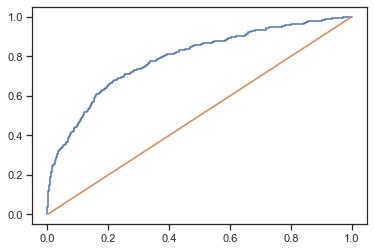

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
recall = recall_score(y_test, preds)
#false discovery rate 
fd = fp/(fp+tp)
fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])

## our roc curve for the lasso regression model 

# XGBoost Model  (Gradient Boosted Decision Tree)

In [35]:
### model, evaluate each predictor using several methods, evaluate model, find cooks distance, retry if necessary. 

In [36]:
from xgboost import XGBClassifier
# the default for the adaboost is decision treee so we dont need to specify that param 
xg = XGBClassifier()
xg.fit(data_scaled_train, y_train)
xg_preds = xg.predict(data_scaled_test)
xg_probs = xg.predict_proba(data_scaled_test)[:, 1]
print('Recall: {:.3f}'.format(recall_score(y_test, xg_preds)))
print('Precision: {:.3f}'.format(precision_score(y_test, xg_preds)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, xg_preds)))
print('ROC AUC: {:.3f}'.format(roc_auc_score(y_test, xg_probs)))

/Users/colinbest/anaconda/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recall: 0.444
Precision: 0.489
Accuracy: 0.900
ROC AUC: 0.838


[0.02255728 0.06123509 0.03040297 0.02361208 0.02534239 0.32403973
 0.04010033 0.07159217 0.03134629 0.07601999 0.02148173 0.02684438
 0.01708382 0.06123057 0.02567622 0.02743172 0.02635304 0.03824656
 0.02398732 0.02541631]


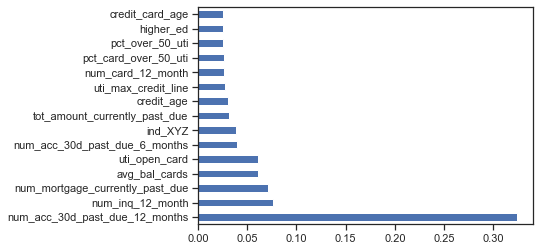

In [37]:
# FEATURE IMPORTANCE 
print(xg.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(xg.feature_importances_, index=feature_names)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [42]:
### Tweaking our xgboost model:

# the default for the adaboost is decision treee so we dont need to specify that param 
xg = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.08,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=2000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
xg.fit(data_scaled_train, y_train)
xg_preds = xg.predict(data_scaled_test)
xg_probs = xg.predict_proba(data_scaled_test)[:, 1]
print('Recall: {:.3f}'.format(recall_score(y_test, xg_preds)))
print('Precision: {:.3f}'.format(precision_score(y_test, xg_preds)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, xg_preds)))
print('ROC AUC: {:.3f}'.format(roc_auc_score(y_test, xg_probs)))

            

/Users/colinbest/anaconda/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:28:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recall: 0.469
Precision: 0.523
Accuracy: 0.906
ROC AUC: 0.873


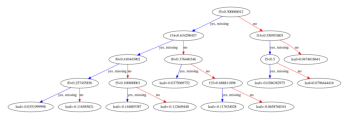

<Figure size 7200x36000 with 0 Axes>

In [43]:
from xgboost import plot_tree
plot_tree(xg)
plt.show()
plt.rcParams["figure.figsize"] = (100,500)
plt.savefig('xgboost')

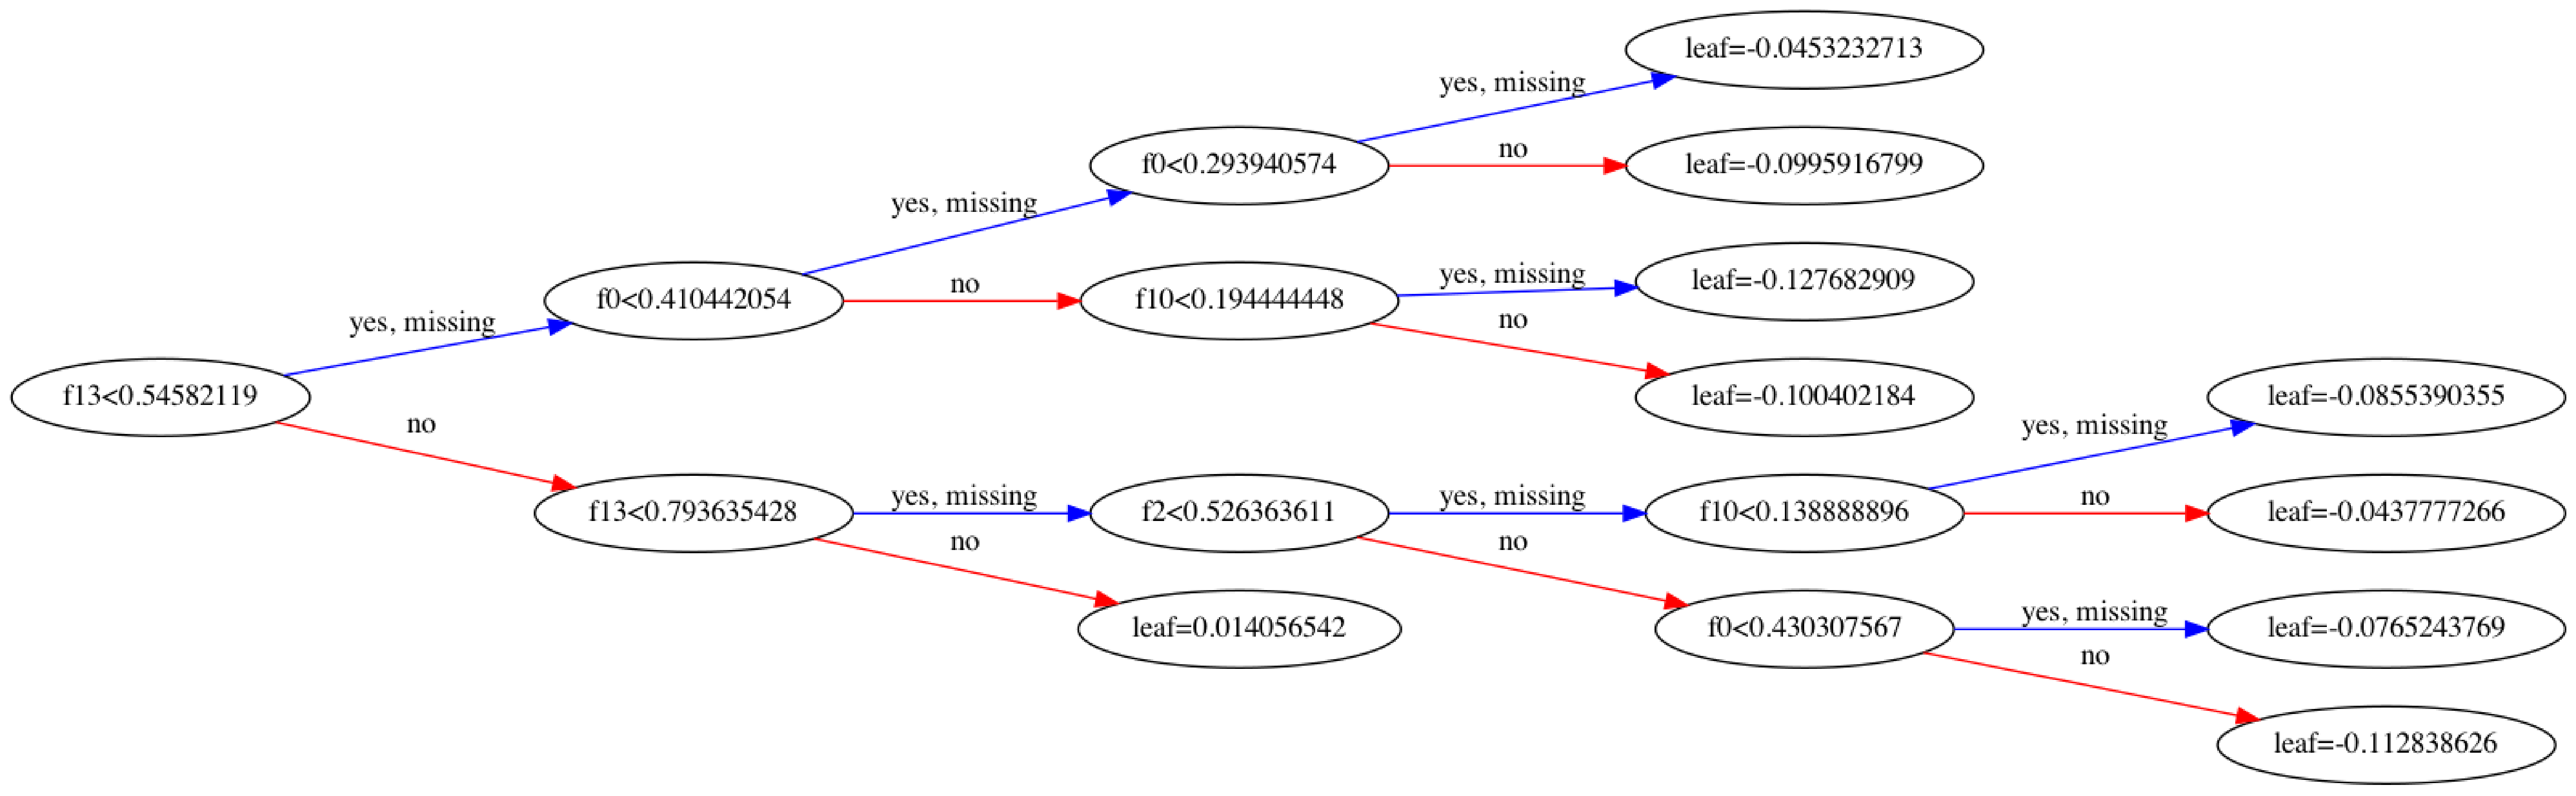

In [44]:
plot_tree(xg, num_trees=2, rankdir='LR')
plt.rcParams["figure.figsize"] = (100,500)

In [45]:
print("model score:",xg.score(data_scaled_test, y_test)) 
# predictions and probabilities calculated 
preds = xg.predict(data_scaled_test)
probs = xg.predict_proba(data_scaled_test)
# taking a look at our confusion matrix for my own reference: 
## top left: true positive, top right: false positive
## bottom left: false negative, bottom right: true negative
confusion_matrix(y_test, preds)

model score: 0.9061214614081781


array([[3555,  173],
       [ 215,  190]])

In [48]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
recall = recall_score(y_test, preds)
#false discovery rate 
fd = fp/(fp+tp)
fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])
plt.plot(fpr,tpr)
#plt.plot([0,1],[0,1])

## our roc curve for the lasso regression model 

## Utilizing Forward feature selection for XG was far too time consuming with this number of variables. With more times I would have explored this a bit further. 

In [41]:
# Tweaking the learning rate and number of trees doesn't seem to help much with our model. Now I will try to use
# sequential forward feature selection to try to get rid of some variables that might be collinear

# sfs1 = sfs(xg,
#            k_features=12,
#            forward=True,
#            floating=False,
#            verbose=2,
#            scoring='accuracy',
#            cv=5)

# # Perform SFFS
# sfs1 = sfs1.fit(data_scaled_train, y_train)

In [ ]:
### Describe how you would use it to make decisions on future credit card applications.

## Describe the importance of the balance between precision and recall are for these particular models in this use case

### The balance between precision and recall for this is very important. In our case a low recall would indicate a large amount of false negatives. This means that we would be predicting that someone would be credit worthy when they are actually someone likely to default. We would likely rather have the reigns a bitter tighter in terms of recall. 

# Do customers who already have an account with the financial institution XYZ receive any favorable treatment in your model? Explain your answer

### I also answered this in my report discussing the ethics of producing a model for this scenario. There are likely credit worthy people who are unlike any of the credit worthy people in our model who may be discriminated against. So yes, it is entirely possible that people who already have an account could receive favorable treatment

In [ ]:
### 